In [87]:
import os
import glob

import numpy as np
import nrrd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import albumentations as A

import torch
from torch import nn
from torchvision.transforms import ToTensor, Resize, Compose, ToPILImage
from torch.utils.data import Dataset, DataLoader
# import pytorch_lightning as pl

## Exploring and preprocessing the data

In [11]:
im_dir = "./images/"
mask_dir = "./masks/"

im_files = sorted(glob.glob(os.path.join(im_dir, "*.nrrd")))
mask_files = sorted(glob.glob(os.path.join(mask_dir, "*.nrrd")))

In [12]:
im, im_header = nrrd.read(im_files[8])
mask, mask_header = nrrd.read(mask_files[8])

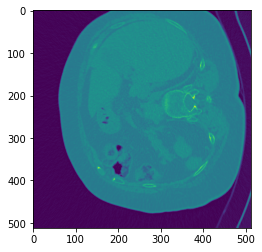

In [257]:
plt.imshow(im[:,:,0])

### Calculate scan mean and std

In [110]:
summ = 0.
n_nums = 0.
for file in tqdm(im_files):
    im, im_header = nrrd.read(file)
    summ += np.double(im).sum()
    n_nums += np.cumprod(im_header['sizes'])[-1]
    
mean = summ / n_nums

print('SCAN MEAN: ', mean)

var = 0.
for file in tqdm(im_files):
    im, im_header = nrrd.read(file)
    var += ((np.double(im) - mean)**2).sum()
    
std = np.sqrt(var / n_nums)

print('SCAN STD: ', std)

### Preprocess and save images for faster training

In [248]:
SCAN_MEAN = -504.8748503279635
SCAN_STD = 495.9326637893348
SCAN_MAX = 400
SCAN_MIN = -1000

binarize_mask = lambda mask : (mask > 0).astype(np.long)
normalize_im = lambda x: ((x - SCAN_MEAN) / SCAN_STD).astype(np.float32)
min_max_scale_im = lambda x: ((x - SCAN_MIN) / (SCAN_MAX - SCAN_MIN)).astype(np.float32)
input_im_transform = lambda x: min_max_scale_im(np.clip(x, SCAN_MIN, SCAN_MAX))

In [ ]:
im_dir = "./images/"
mask_dir = "./masks/"

im_files = sorted(glob.glob(os.path.join(im_dir, "*.nrrd")))
mask_files = sorted(glob.glob(os.path.join(mask_dir, "*.nrrd")))

In [76]:
os.mkdir('./CAD_PE_small')
os.mkdir('./CAD_PE_small/images/')
os.mkdir('./CAD_PE_small/masks/')

tr = Compose([
        ToTensor(),
        Resize(256)
    ])

filename_getter = lambda name: os.path.splitext(os.path.basename(name))[0]

save_im_dir = './CAD_PE_small/images/'
save_mask_dir = './CAD_PE_small/masks/'

for im_file, mask_file in tqdm(zip(im_files, mask_files)):
    im, _ = nrrd.read(im_file)
    mask, _ = nrrd.read(mask_file)

    im_small = tr(input_im_transform(im))
    mask_small = tr(binarize_mask(mask))

    im_filename = filename_getter(im_file)
    mask_filename = filename_getter(mask_file)

    np.save(f"{save_im_dir}/{im_filename}", im_small.numpy())
    np.save(f"{save_mask_dir}/{mask_filename}", mask_small.numpy())    

### How many scans with empty masks? Their names?

In [84]:
im_dir = "./CAD_PE_small/images"
mask_dir = "./CAD_PE_small/masks/"

im_files = sorted(glob.glob(os.path.join(im_dir, "*.npy")))
mask_files = sorted(glob.glob(os.path.join(mask_dir, "*.npy")))

In [85]:
n_empty = 0
for mask_file in tqdm(mask_files):
    mask = np.load(mask_file)
    s = (mask > 0).sum() == 0
    n_empty += s
    if s:
        print(mask_file, mask.shape[0])

### Deleting some images without PE to make dataset more ballanced

In [16]:
im_dir = "./CAD_PE_small/images/"
mask_dir = "./CAD_PE_small/masks/"

im_files = sorted(glob.glob(os.path.join(im_dir, "*.npy")))
mask_files = sorted(glob.glob(os.path.join(mask_dir, "*.npy")))

In [30]:
filename_getter = lambda name: os.path.splitext(os.path.basename(name))[0]

save_im_dir = './CAD_PE_small_b/images/'
save_mask_dir = './CAD_PE_small_b/masks/'

for im_file, mask_file in tqdm(zip(im_files, mask_files), total=len(im_files)):
    im = np.load(im_file)
    mask = np.load(mask_file)
    
    num_frames = im.shape[0]
    ids = set(range(num_frames))

    pe_imgs = mask.sum((1,2)) > 0
    good_ids = set(list(np.where(pe_imgs)[0]))
#     good_ids = {i + di for i in good_ids for di in range(-2, 3) if 0 <= i + di < num_frames}

    bad_ids = np.array(list(ids - good_ids))

    num_to_drop = (num_frames + 1) // 2
    kept_bad_ids = set(list(np.random.permutation(bad_ids)[num_to_drop:]))

    final_ids = np.array(list(good_ids | kept_bad_ids))
    
    zip_ratio = len(final_ids) / len(ids)
    print(f"{im_file} -> zip ratio: {zip_ratio}")

    im = im[final_ids]
    mask = mask[final_ids]

    im_filename = filename_getter(im_file)
    mask_filename = filename_getter(mask_file)

    np.save(f"{save_im_dir}/{im_filename}", im)
    np.save(f"{save_mask_dir}/{mask_filename}", mask)

./CAD_PE_small/images\001.npy -> zip ratio: 0.5
./CAD_PE_small/images\002.npy -> zip ratio: 0.49794238683127573
./CAD_PE_small/images\003.npy -> zip ratio: 0.5
./CAD_PE_small/images\004.npy -> zip ratio: 0.49928469241773965
./CAD_PE_small/images\005.npy -> zip ratio: 0.49783549783549785
./CAD_PE_small/images\006.npy -> zip ratio: 0.4991364421416235
./CAD_PE_small/images\007.npy -> zip ratio: 0.6077481840193705
./CAD_PE_small/images\008.npy -> zip ratio: 0.5
./CAD_PE_small/images\009.npy -> zip ratio: 0.49870801033591733
./CAD_PE_small/images\010.npy -> zip ratio: 0.5
./CAD_PE_small/images\011.npy -> zip ratio: 0.5
./CAD_PE_small/images\012.npy -> zip ratio: 0.5
./CAD_PE_small/images\013.npy -> zip ratio: 0.49914529914529915
./CAD_PE_small/images\014.npy -> zip ratio: 0.49916805324459235
./CAD_PE_small/images\015.npy -> zip ratio: 0.5989847715736041
./CAD_PE_small/images\016.npy -> zip ratio: 0.5
./CAD_PE_small/images\017.npy -> zip ratio: 0.49808429118773945
./CAD_PE_small/images\018.n

### Calculate total number of images

In [198]:
im_dir = "./CAD_PE_small_b/images/"
mask_dir = "./CAD_PE_small_b/masks/"

im_files = sorted(glob.glob(os.path.join(im_dir, "*.npy")))
mask_files = sorted(glob.glob(os.path.join(mask_dir, "*.npy")))

In [199]:
scan_sizes = []
for file in tqdm(im_files):
    im = np.load(file)
    scan_sizes.append(im.shape[0])

In [200]:
print(scan_sizes)

[144, 121, 312, 349, 115, 289, 251, 295, 193, 213, 327, 242, 292, 300, 354, 245, 130, 282, 212, 300, 247, 255, 120, 257, 310, 289, 259, 268, 255, 286, 145, 129, 323, 328, 275, 290, 221, 293, 322, 282, 279, 216, 54, 225, 202, 290, 347, 46, 253, 241, 296, 356, 51, 47, 262, 249, 207, 359, 250, 129, 160, 235, 350, 119, 45, 43, 40, 284, 226, 138, 282, 290, 183, 355, 287, 46, 263, 41, 197, 307, 44, 145, 304, 333, 275, 209, 300, 270, 205, 126, 226]


In [201]:
cumsum = np.cumsum(scan_sizes)

print('Total number of images =', cumsum[-1])

Total number of images = 20807


In [202]:
cumsum

array([  144,   265,   577,   926,  1041,  1330,  1581,  1876,  2069,
        2282,  2609,  2851,  3143,  3443,  3797,  4042,  4172,  4454,
        4666,  4966,  5213,  5468,  5588,  5845,  6155,  6444,  6703,
        6971,  7226,  7512,  7657,  7786,  8109,  8437,  8712,  9002,
        9223,  9516,  9838, 10120, 10399, 10615, 10669, 10894, 11096,
       11386, 11733, 11779, 12032, 12273, 12569, 12925, 12976, 13023,
       13285, 13534, 13741, 14100, 14350, 14479, 14639, 14874, 15224,
       15343, 15388, 15431, 15471, 15755, 15981, 16119, 16401, 16691,
       16874, 17229, 17516, 17562, 17825, 17866, 18063, 18370, 18414,
       18559, 18863, 19196, 19471, 19680, 19980, 20250, 20455, 20581,
       20807], dtype=int32)

### Compare val and train datasets

In [63]:
im_dir = "./val_small_b/images"
mask_dir = "./val_small_b/masks/"

im_files = sorted(glob.glob(os.path.join(im_dir, "*.npy")))
mask_files = sorted(glob.glob(os.path.join(mask_dir, "*.npy")))

In [64]:
n1_val = 0
n_scans_val = 0
for mask_f in mask_files:
    mask = np.load(mask_f)
    n1_val += mask.sum()
    n_scans_val += mask.shape[0]

In [77]:
im_dir = "./train_small_b/images"
mask_dir = "./train_small_b/masks/"

im_files = sorted(glob.glob(os.path.join(im_dir, "*.npy")))
mask_files = sorted(glob.glob(os.path.join(mask_dir, "*.npy")))

In [78]:
n1_train = 0
n_scans_train = 0
for mask_f in mask_files:
    mask = np.load(mask_f)
    n1_train += mask.sum()
    n_scans_train += mask.shape[0]

In [80]:
n1_val / n_scans_val

32.143894689060375

In [81]:
n1_train / n_scans_train

48.21108468995793

In [82]:
n_scans_train

16401

In [83]:
n_scans_val

4406

In [17]:
4406 / (4406 + 16401)

0.2117556591531696

## Training models

In [3]:
import os
import glob

import numpy as np
import nrrd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import albumentations as A

import torch
from torch import nn
from torchvision.transforms import ToTensor, Resize, Compose, ToPILImage
from torch.utils.data import Dataset, DataLoader
# import pytorch_lightning as pl

import dataset, metrics, loss
from filter_model import FilterSegModel
from torch.utils.tensorboard import SummaryWriter
import segmentation_models_pytorch as smp

In [3]:
def train(model, train_dataloader, val_dataloader,
          optimizer=None, scheduler=None, criterion=None, n_epoch=50, writer=None, save_dir='./'):

    device = next(iter(model.parameters())).device

    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters())
    if criterion is None:
        criterion = nn.BCEWithLogitsLoss()

#     best_val_dice = float('-inf')
    best_val_dice_soft = float('-inf')
    prev_best_model = "no_such_model"

    print_every_iters = 200

    for epoch in tqdm(range(n_epoch)):
        model.train()
        tr_loss, tr_acc, tr_dice, tr_dice_soft, tr_iou, tr_iou_soft = 0, 0, 0, 0, 0, 0
        for i, batch in enumerate(tqdm(train_dataloader, leave=False, desc="Train iters")):
            im, mask = batch

            preds = model(im.to(device)).cpu()
            loss = criterion(preds, mask)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if scheduler is not None:
                scheduler.step()

            tr_loss += loss.item()
            tr_acc  += metrics.Accuracy(preds, mask)
            tr_dice += metrics.DiceScore(preds, mask) 
            tr_dice_soft +=  metrics.DiceScoreSoft(preds, mask)
            tr_iou += metrics.IoU(preds, mask)
            tr_iou_soft += metrics.IoUSoft(preds, mask)

            if (i + 1) % print_every_iters == 0 or i == len(train_dataloader) - 1:
                # Print train metrics
                num_iters = i % print_every_iters + 1
                epoch_for_writer = epoch * len(train_dataloader) + i + 1

                train_loss = tr_loss / num_iters
                train_acc  = tr_acc  / num_iters
                train_dice = tr_dice / num_iters
                train_dice_soft = tr_dice_soft / num_iters
                train_iou  = tr_iou / num_iters
                train_iou_soft  = tr_iou_soft / num_iters
                
                writer.add_scalar('Loss/train', train_loss, epoch_for_writer)
                writer.add_scalar('Acc/train', train_acc, epoch_for_writer)
                writer.add_scalar('DiceScore/train', train_dice, epoch_for_writer)
                writer.add_scalar('DiceScoreSoft/train', train_dice_soft, epoch_for_writer)
                writer.add_scalar('IoU/train', train_iou, epoch_for_writer)
                writer.add_scalar('IoUSoft/train', train_iou_soft, epoch_for_writer)
                

                print(f'Epoch: {epoch + 1:>2}, iter: {i + 1:>4}, epoch for writer: {epoch_for_writer}')
                print(f"\tTrain Loss: {train_loss:.4f} | "
                      f"Train dice: {train_dice:.4f} | "
                      f"Train dice_soft: {train_dice_soft:.4f}")
                tr_loss, tr_acc, tr_dice, tr_dice_soft, tr_iou, tr_iou_soft = 0, 0, 0, 0, 0, 0

                # Calculate val metrics
                model.eval()

                val_loss, val_acc, val_dice, val_dice_soft, val_iou, val_iou_soft = 0, 0, 0, 0, 0, 0
                for im, mask in tqdm(val_dataloader, leave=False, desc="Validation iters"):
                    with torch.no_grad():
                        preds = model(im.to(device)).cpu()
                        loss = criterion(preds, mask)

                        val_loss += loss.item()
                        val_acc  += metrics.Accuracy(preds, mask)
                        val_dice += metrics.DiceScore(preds, mask) 
                        val_dice_soft +=  metrics.DiceScoreSoft(preds, mask)
                        val_iou += metrics.IoU(preds, mask)
                        val_iou_soft += metrics.IoUSoft(preds, mask)

                # Print val metrics and update the best model
                val_loss /= len(val_dataloader)
                val_acc  /= len(val_dataloader)
                val_dice /= len(val_dataloader)
                val_dice_soft /= len(val_dataloader)
                val_iou  /= len(val_dataloader)
                val_iou_soft  /= len(val_dataloader)

                if val_dice_soft > best_val_dice_soft:
                    best_val_dice_soft = val_dice_soft

                    model_name = (
                        f"acc={val_acc:0.3f}_"
                        f"dice={val_dice:0.3f}_"
                        f"dice_soft={val_dice_soft:0.3f}_"
                        f"iou={val_iou:0.3f}_"
                        f"iou_soft={val_iou_soft:0.3f}_"
                        f"epoch={epoch}.pth"
                    )

                    checkpoint_path = os.path.join(save_dir, model_name)

                    if os.path.exists(prev_best_model):
                        os.remove(prev_best_model)
                        
                    prev_best_model = checkpoint_path
                    torch.save(model.state_dict(), checkpoint_path)

                writer.add_scalar('Loss/val', val_loss, epoch_for_writer)
                writer.add_scalar('Acc/val', val_acc, epoch_for_writer)
                writer.add_scalar('DiceScore/val', val_dice, epoch_for_writer)
                writer.add_scalar('DiceScoreSoft/val', val_dice_soft, epoch_for_writer)
                writer.add_scalar('IoU/val', val_iou, epoch_for_writer)
                writer.add_scalar('IoUSoft/val', val_iou_soft, epoch_for_writer)
                print(f'\t Val. Loss: {val_loss:.4f} | '
                      f' Val. dice: {val_dice:.4f} | '
                      f' Val. dice_soft: {val_dice_soft:.4f}')

                model.train()

In [4]:
train_dataset, val_dataset = dataset.get_CADDataset('./train_small_b/', './val_small_b/', augment_data=False)

***Dataset initialization can take several minutes!***



***Done!***
***Dataset initialization can take several minutes!***



***Done!***


In [5]:
train_dataloader = dataset.CADDataloader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = dataset.CADDataloader(val_dataset, batch_size=16)

In [40]:
%load_ext tensorboard

In [41]:
%tensorboard --logdir ./logs/ --host 192.168.1.100

Reusing TensorBoard on port 6006 (pid 571496), started 6 days, 9:47:29 ago. (Use '!kill 571496' to kill it.)

In [ ]:
version = 6
save_dir = f"./logs/loss=BCE+Dice_w=0.8_ds=small_b_sch/v{version}"
writer = SummaryWriter(log_dir=save_dir)

model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                       in_channels=1, out_channels=1, init_features=32, pretrained=False).to('cuda')


# model = smp.Unet(encoder_name='resnet18',
#                  encoder_depth=3,
#                  decoder_channels=(64, 32, 16),
#                  in_channels=1,
#                  activation='sigmoid')

# model = smp.Unet(encoder_name='mobilenet_v2',
#                  encoder_depth=3,
#                  decoder_channels=(64, 32, 16),
#                  in_channels=1,
#                  activation='sigmoid')


# fmodel = FilterSegModel(model, 1, 256, 256)

optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer=torch.optim.Adam(fmodel.parameters(), lr=1e-3)
# scheduler = None
scheduler=torch.optim.lr_scheduler.StepLR(optimizer, 200, gamma=0.9)

train(model, train_dataloader, val_dataloader,
# train(fmodel, train_dataloader, val_dataloader,
      optimizer=optimizer,
      scheduler=scheduler,
#       criterion = nn.BCELoss(),
      criterion=loss.DiceBCELoss(w=0.8), 
      n_epoch=5, writer=writer, save_dir=save_dir)

### Results

In [59]:
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
from collections import defaultdict
import numpy as np


def get_events(log_dir):
    files = sorted(glob.glob(os.path.join(log_dir, "v*/events*")))
    result = defaultdict(list)
    
    for file in files:
        sum_it = summary_iterator(file)

        events = defaultdict(list)
        for elem in sum_it:
            for v in elem.summary.value:
                events[v.tag].append(v.simple_value)
                
        for key, value in events.items():
            result[key].append(value)
            
    for key, value in results.items():
        result[key] = np.array(result[key])
            
    return result

In [165]:
import pandas as pd
import seaborn as sns


def plot_conf_int(events, key, label=None):
    df = pd.DataFrame(events[key])
    df = df.melt(value_vars=df.columns, var_name='t')
    
    sns.lineplot(data=df, x='t', y='value', label=label)
    
def plot_comparison(events, events_filter, key, save=True, save_dir='./'):
    plot_conf_int(events, key, 'no filter')
    plot_conf_int(events_filter, key, 'with filter')
    plt.grid()
    plt.title(key)
    if save:
        plt.savefig(os.path.join(save_dir, '_'.join(key.split('/'))))

    plt.show()

#### BCE  loss with scheduler

In [141]:
log_dir = "./logs/loss=BCE_ds=small_b_sch/"
events = get_events(log_dir)

log_dir_filter = "./logs/filter=g2d_loss=BCE=small_b_sch/"
events_filter = get_events(log_dir_filter)

In [162]:
os.mkdir('./plots')
os.mkdir('./plots/BCE_sch')

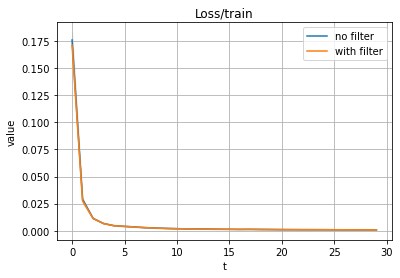

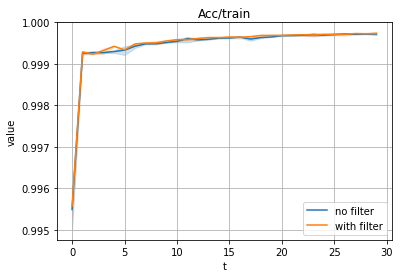

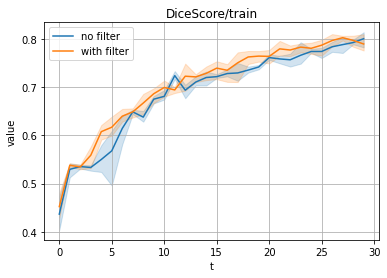

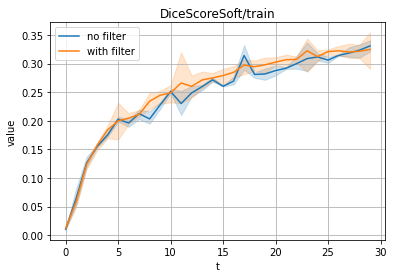

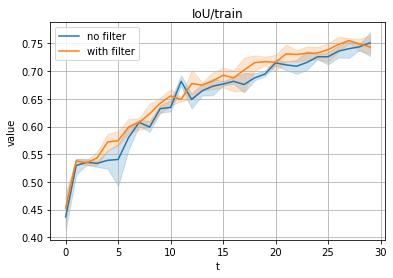

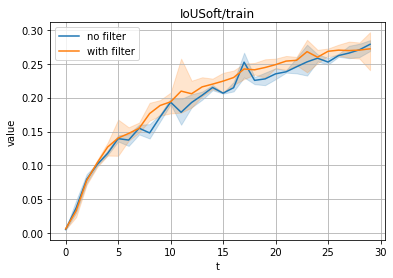

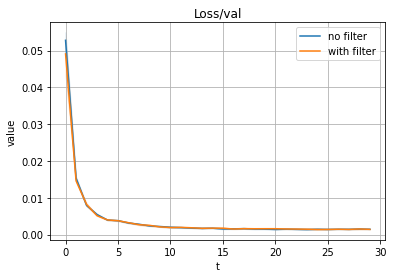

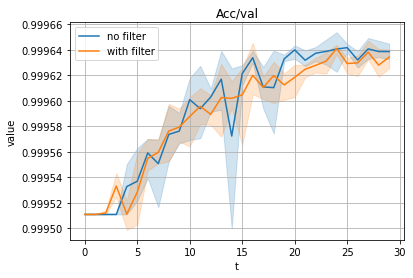

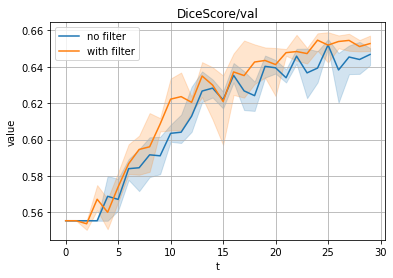

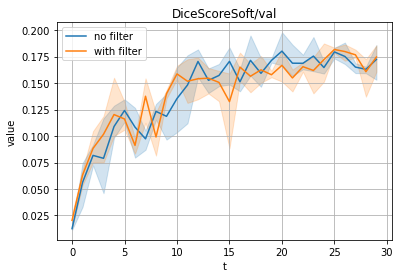

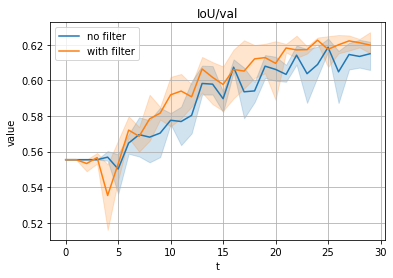

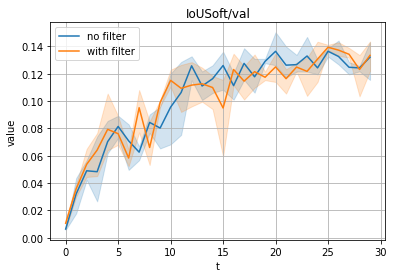

In [166]:
for key in events.keys():
    plot_comparison(events, events_filter, key, save_dir='./plots/BCE_sch/')

#### BCE+Dice  loss with scheduler

In [170]:
log_dir = "./logs/loss=BCE+Dice_w=0.8_ds=small_b_sch/"
events = get_events(log_dir)

log_dir_filter = "./logs/filter=g2d_loss=BCE+Dice_w=0.8_ds=small_b_sch/"
events_filter = get_events(log_dir_filter)

In [168]:
os.mkdir('./plots/BCE+Dice_w=0.8_sch')

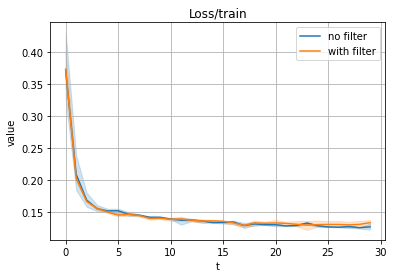

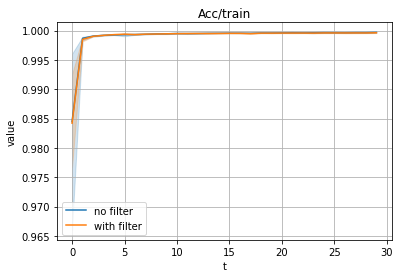

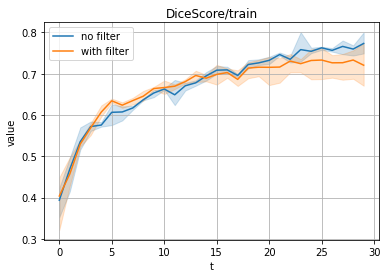

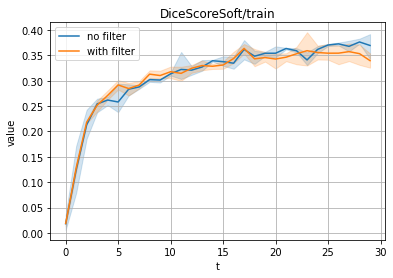

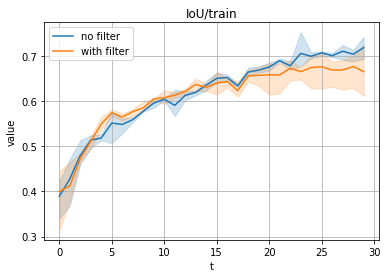

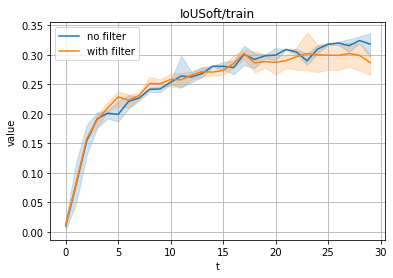

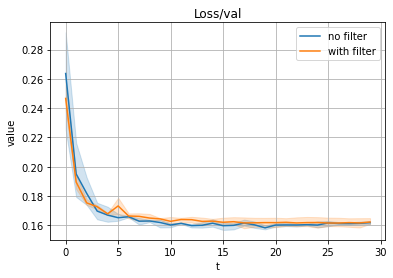

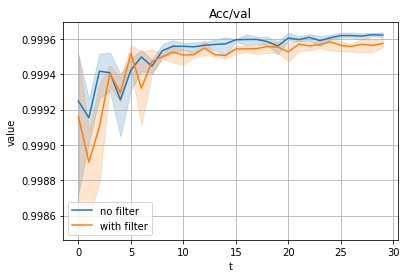

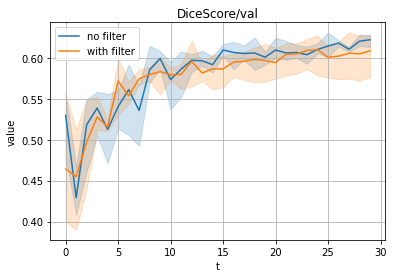

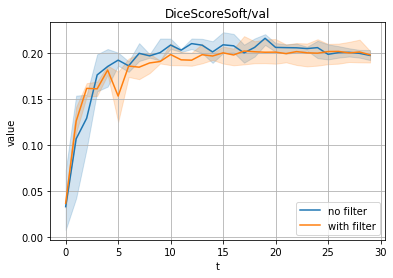

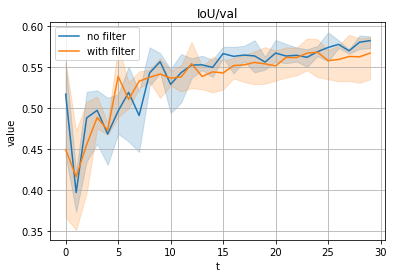

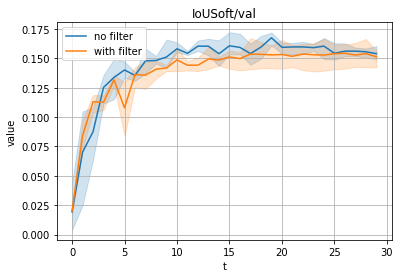

In [172]:
for key in events.keys():
    plot_comparison(events, events_filter, key, save_dir='./plots/BCE+Dice_w=0.8_sch')

#### Visualizing filtering

In [23]:
state_dict = torch.load('./logs/filter=g2d_loss=BCE=small_b_sch/v3/acc=1.000_dice=0.654_dice_soft=0.187_iou=0.619_iou_soft=0.143_epoch=4.pth')

In [ ]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                       in_channels=1, out_channels=1, init_features=32, pretrained=False).to('cuda')

fmodel = FilterSegModel(model, 1, 256, 256)

In [24]:
fmodel.load_state_dict(state_dict)

<All keys matched successfully>

In [79]:
dl = iter(val_dataloader)

for i in range(25):
    im, mask = next(dl)

In [81]:
fim = fmodel.filter(im.cuda()).cpu()

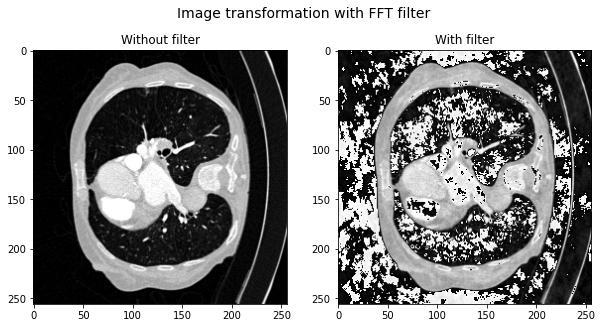

In [30]:
plt.subplots(1,2, figsize=(10, 7))
plt.subplot(1,2,1)
plt.imshow(ToPILImage()(im[15][0]), cmap='gray')
plt.title('Without filter')

plt.subplot(1,2,2)
plt.imshow(ToPILImage()(fim.detach()[15][0]), cmap='gray')
plt.title('With filter')

plt.suptitle('Image transformation with FFT filter', y=0.84, fontsize=14)
plt.savefig('./plots/filter')
plt.show()

#### visualizing predictions

In [82]:
preds = fmodel.cuda()(im.cuda()).cpu()

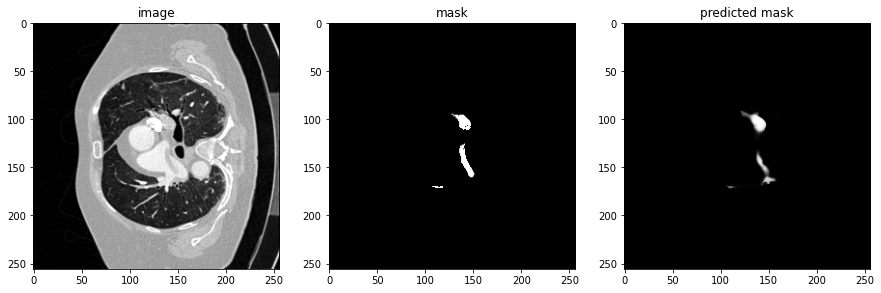

In [85]:
plt.subplots(1,3, figsize=(15, 6))
plt.subplot(1,3,1)
plt.imshow(ToPILImage()(im[15][0]), cmap='gray')
plt.title('image')

plt.subplot(1,3,2)
plt.imshow(ToPILImage()(mask[15][0]), cmap='gray')
plt.title('mask')

plt.subplot(1,3,3)
# plt.imshow(ToPILImage()((preds[15][0] > 0.4).float()), cmap='gray')
plt.imshow(ToPILImage()(preds[15][0]), cmap='gray')
plt.title('predicted mask')

plt.savefig('./plots/res06')
plt.show()